Editor | Date | Comment
--- | --- | ---
Alireza Ranjbar | 27.12.2018 | Initial version

In [2]:
import os
import io
import glob
import blockdiag
from blockdiag import parser, builder, drawer, noderenderer
from blockdiag.metrics import DiagramMetrics
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
from importlib import reload
import numpy as np

In [25]:
def _create_fontmap(fontmap, font):
    """
    Inspired from :epkg:`blockdiag` source file (*_bootstrap.py*).
    """
    from blockdiag.utils.fontmap import FontMap
    fontmap = FontMap(fontmap)
    if fontmap.find().path is None or font:
        fontpath = _detectfont(font)
        fontmap.set_default_font(fontpath)
    return fontmap

In [122]:
fontmap = blockdiag.utils.fontmap.FontMap()
fontmap.set_default_font(path = 'c:/windows/fonts\\georgia.ttf')

In [123]:
fontmap.append_font(fontfamily='sansserif', path = 'c:/windows/fonts\\Gabriola.ttf')

In [110]:
fontmap.default_fontfamily = 'georgia'

In [71]:
for root, _, files in os.walk('c:/windows/fonts/'):
    for font_ in files:
        fontpath = os.path.join(root, font_)

In [72]:
files

['8514fix.fon',
 '8514fixe.fon',
 '8514fixg.fon',
 '8514fixr.fon',
 '8514fixt.fon',
 '8514oem.fon',
 '8514oeme.fon',
 '8514oemg.fon',
 '8514oemr.fon',
 '8514oemt.fon',
 '8514sys.fon',
 '8514syse.fon',
 '8514sysg.fon',
 '8514sysr.fon',
 '8514syst.fon',
 '85775.fon',
 '85855.fon',
 '85f1255.fon',
 '85f1256.fon',
 '85f1257.fon',
 '85f874.fon',
 '85s1255.fon',
 '85s1256.fon',
 '85s1257.fon',
 '85s874.fon',
 'AGENCYB.TTF',
 'AGENCYR.TTF',
 'ALGER.TTF',
 'ANTQUAB.TTF',
 'ANTQUABI.TTF',
 'ANTQUAI.TTF',
 'app775.fon',
 'app850.fon',
 'app852.fon',
 'app855.fon',
 'app857.fon',
 'app866.fon',
 'app932.fon',
 'app936.fon',
 'app949.fon',
 'app950.fon',
 'arial.ttf',
 'arialbd.ttf',
 'arialbi.ttf',
 'ariali.ttf',
 'ARIALN.TTF',
 'ARIALNB.TTF',
 'ARIALNBI.TTF',
 'ARIALNI.TTF',
 'ARIALUNI.TTF',
 'ariblk.ttf',
 'ARLRDBD.TTF',
 'bahnschrift.ttf',
 'BASKVILL.TTF',
 'BAUHS93.TTF',
 'BELL.TTF',
 'BELLB.TTF',
 'BELLI.TTF',
 'BERNHC.TTF',
 'BKANT.TTF',
 'BOD_B.TTF',
 'BOD_BI.TTF',
 'BOD_BLAI.TTF',
 'BOD_B

In [60]:
a=[]
for root, c, files in os.walk('c:/windows/fonts/'):
    for file in files:
        a.append(root+file)
        fontpath = os.path.join(root, file)

The below string is the main input which discribes the relation between the blocks, colors, and various settings which are elaborated in the documentation of Blockdiag package.

The idea is so far to have a script which generates the below string automatically based on a given table (e.g. pandas DataFrame) which includes the information such as node colors and nodes relation (parent/child shown by the direction of the arrow or a neutral relation with no direction and merely a connection between the two nodes).

Having used the logic behind the blockdiag kit, the output pillow image is used to paste the remaining information (such as the image of the flags) on the nodes, with the coordinates provided by the blockdiag output.

In [756]:
columns = ['node_id',
           'directed_to',
           'direction_type',
           'label',
           'node_flag',
           'shape',
           'stacked',
           'linecolor',
           'color',
           'style',
           'textcolor',
           'width',
           'height',
           'fontsize',
           'numbered',
           'description',
           'background',
           'group']
input_df = pd.DataFrame(columns=columns)

In [757]:
for i in range(7):
    input_df.at[i,'node_id'] = i
    input_df.at[i,'shape'] = 'box'
    input_df.at[i,'label'] = 'label_'+str(i)
    input_df.at[i,'fontsize'] = '10'
    input_df.at[i,'stacked'] = ''
    input_df.at[i,'directed_to'] = []
    input_df.at[i,'direction_type'] = []
    input_df.at[i,'linecolor'] = 'white'
    input_df.at[i,'color'] = '#d3d3d3'

In [758]:
input_df.at[0,'directed_to'] = [1,]
input_df.at[0,'direction_type'] = ['towards']

input_df.at[1,'directed_to'] = [2,]
input_df.at[1,'direction_type'] = ['normal',]

input_df.at[2,'directed_to'] = [3,]
input_df.at[2,'direction_type'] = ['normal',]

input_df.at[3,'directed_to'] = [4,5,]
input_df.at[3,'direction_type'] = ['towards','towards',]

#input_df.at[4,'directed_to'] = 
#input_df.at[4,'direction_type'] = () 

input_df.at[5,'directed_to'] = [6,]
input_df.at[5,'direction_type'] = ['bidirectional',]

#input_df.at[6,'directed_to'] = ()
#input_df.at[6,'direction_type'] = () 


In [759]:
relation={'towards': ' -> ',
          'backwards': ' <- ',
          'normal': ' -- ',
          'bidirectional': ' <-> '}

In [761]:
input_df.fillna('', inplace=True)

In [736]:
columns = ['node_id',
           'directed_to',
           'direction_type',
           'label',
           'node_flag',
           'shape',
           'stacked',
           'line_color',
           'color',
           'style',
           'textcolor',
           'width',
           'height',
           'fontsize',
           'numbered',
           'description',
           'background',
           'group']

In [766]:
def parse_df_to_string(input_df):
    edges_relation=[]
    all_nodes_attributes_string=[]
    for node_id, node_attributes in input_df.iterrows():
        node_attributes = input_df.iloc[node_id]
        for child_id, direction_type in zip(node_attributes['directed_to'], node_attributes['direction_type']):
            edges_relation.append(str(node_id) + relation[direction_type]+str(child_id))
        node_attributes_string =  str(node_id)    +'['
        for attr_name, attr_value in node_attributes.iteritems():
            if attr_value and attr_name not in ['directed_to','direction_type','node_id']:
                node_attributes_string += attr_name+'="'+attr_value+'",' 
        all_nodes_attributes_string.append(node_attributes_string[:-1]+']' )
    defaults = 'orientation = portrait;node_width =130;node_height = 50;default_node_color = "#d3d3d3"; default_group_color = "#7777FF";default_linecolor = black;'    
    string_commands=edge_relation+ all_nodes_attributes_string
    return '{' +";".join(string_commands)+defaults+'}'

In [ ]:
['directed_to','direction_type','node_id','node_flag','stacked']

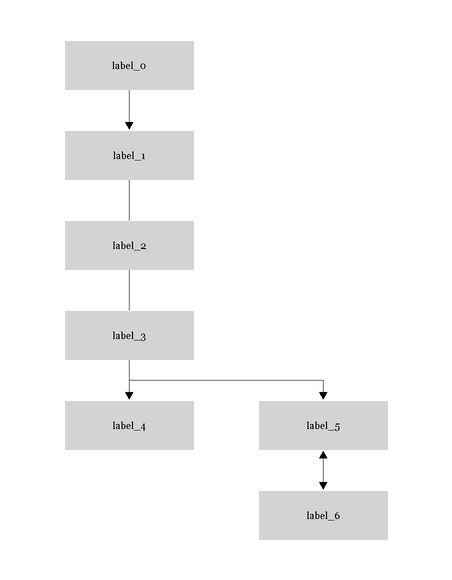

In [767]:
draw_diagram(parse_df_to_string(input_df))

In [762]:
edges_relation=[]
all_nodes_attributes_string=[]
for node_id, node_attributes in input_df.iterrows():
    node_attributes = input_df.iloc[node_id]
    for child_id, direction_type in zip(node_attributes['directed_to'], node_attributes['direction_type']):
        edges_relation.append(str(node_id) + relation[direction_type]+str(child_id))

    node_attributes_string =  str(node_id)    +'['
    for attr_name, attr_value in node_attributes.iteritems():

        if attr_value and attr_name not in ['directed_to','direction_type','node_id','group']:
            
            node_attributes_string += attr_name+'="'+attr_value+'",'
    #node_attributes_string        
    all_nodes_attributes_string.append(node_attributes_string[:-1]+']' )

defaults = 'orientation = portrait;node_width =130;node_height = 50;default_node_color = "#d3d3d3"; default_group_color = "#7777FF";default_linecolor = black;'    
string_commands=edge_relation+ all_nodes_attributes_string
string_commands = '{' +";".join(string_commands)+defaults+'}'

In [549]:
def draw_diagram(string_commands):
    output_formatv = "png" #or svg,
    default_shadow_color = (255, 255, 255) # RGB white
    default_nodeline_color = (255, 255, 255) # RGB white
    size=None
    graph_string = string_commands
    tree = parser.parse_string(graph_string)

    diagram = blockdiag.builder.ScreenNodeBuilder.build(tree, None)
    diagram.separated=True
    diagram.set_color('red')
    diagram.set_orientation('portrait')


    diagram.set_default_linecolor(default_nodeline_color)
    

    fontmap = blockdiag.utils.fontmap.FontMap()
    fontmap.set_default_font(path = 'c:/windows/fonts\\georgia.ttf')
    
    metrics = DiagramMetrics(diagram=diagram, drawer=None, fontmap=fontmap)
    #fontmap.set_default_fontfamily(fontfamily='serif-bold')
    #fontmap.set_default_fontfamily(fontfamily='serif')
    fontmap.fontsize =10
    #fontmap = _create_fontmap(fontmap=None, font=None)

    drawer = blockdiag.drawer.DiagramDraw(_format=output_formatv,
                                          diagram=diagram,
                                          fontmap=fontmap,
                                          code=graph_string,
                                          antialias=True,
                                          nodoctype=False,
                                          transparency=False)

    drawer.shadow=default_shadow_color





    drawer.draw()
    res = drawer.save()
    if output_formatv=="png":
        img = Image.open(io.BytesIO(res))
    return img, drawer

In [763]:
all_nodes_attributes_string

['0[label="label_0",shape="box",linecolor="white",color="#d3d3d3",fontsize="10"]',
 '1[label="label_1",shape="box",linecolor="white",color="#d3d3d3",fontsize="10"]',
 '2[label="label_2",shape="box",linecolor="white",color="#d3d3d3",fontsize="10"]',
 '3[label="label_3",shape="box",linecolor="white",color="#d3d3d3",fontsize="10"]',
 '4[label="label_4",shape="box",linecolor="white",color="#d3d3d3",fontsize="10"]',
 '5[label="label_5",shape="box",linecolor="white",color="#d3d3d3",fontsize="10"]',
 '6[label="label_6",shape="box",linecolor="white",color="#d3d3d3",fontsize="10"]']

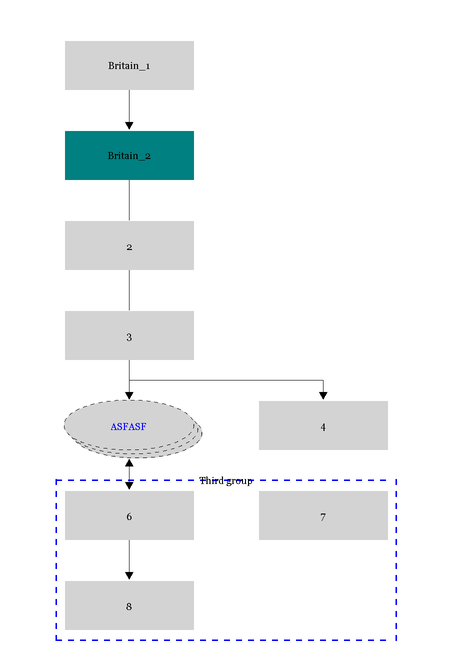

In [705]:
graph_string = """{
//default settings'documentation:
// http://blockdiag.com/en/blockdiag/attributes/diagram.attributes.html?highlight=default#blockdiag_diagram_attr-default_fontsize
// 1 -> 2 makes two nodes with ids of 1 and 2 where 1 has an edge pointing towards 2. Using these ids, a label can
// be written for the nodes as shown. These ids can also be later used for knowing the coordinates of the nodes.
    
    
    // Set span metrix
     //  span_height = 90;
      // span_width = 160;
       
    
    orientation = portrait
        5 <-> 6; 5[label = 'ASFASF'];
        
        0 -> 1;  0 [label = "Britain_1"]; 1 [label = "Britain_2",color  = "#008080"];
                    // 0 [label = "Britain_1"]; //0[fontsize = 25 ]; //0[fontfamily='-sansserif-bold'];
        
        
        1 -- 2;  1 [label = "Label4  \n label5 \n label6"];
        2 -- 3;   
        3 -> 4;  // [thick]   ;
        3 -> 5; 5 [shape = "ellipse", stacked, style = dashed, linecolor=black,textcolor=blue] ;

        
//define default parameters 

   // defaultnode sizes
        node_width =130;
        node_height = 50;
        
    // default colors
        default_node_color = "#d3d3d3";
        
        
        default_group_color = "#7777FF";
        default_linecolor = black;
      
// give a specific color to a node:

      
// showing certain nodes in one group:
      group {
              // set the group label text and its color
              label = "Third group";
              color =blue //"#0000FF";

              // Set group shape to 'line group' (default is box)
              shape = line;

              // Set line style (effects to 'line group' only)
              style = dashed;
               6 -> 8 ;7
             }
             0 [label = "Britain_1"]; 1 [label = "Britain_2"];
}"""

draw_diagram(graph_string)

In [754]:
input_df

,node_id,directed_to,direction_type,label,node_flag,shape,stacked,line_color,color,style,textcolor,width,height,fontsize,numbered,description,background,group
0,0,[1],[towards],label_0,,box,,white,#d3d3d3,,,,,10,,,,
1,1,[2],[normal],label_1,,box,,white,#d3d3d3,,,,,10,,,,
2,2,[3],[normal],label_2,,box,,white,#d3d3d3,,,,,10,,,,
3,3,"[4, 5]","[towards, towards]",label_3,,box,,white,#d3d3d3,,,,,10,,,,
4,4,[],[],label_4,,box,,white,#d3d3d3,,,,,10,,,,
5,5,[6],[bidirectional],label_5,,box,,white,#d3d3d3,,,,,10,,,,
6,6,[],[],label_6,,box,,white,#d3d3d3,,,,,10,,,,


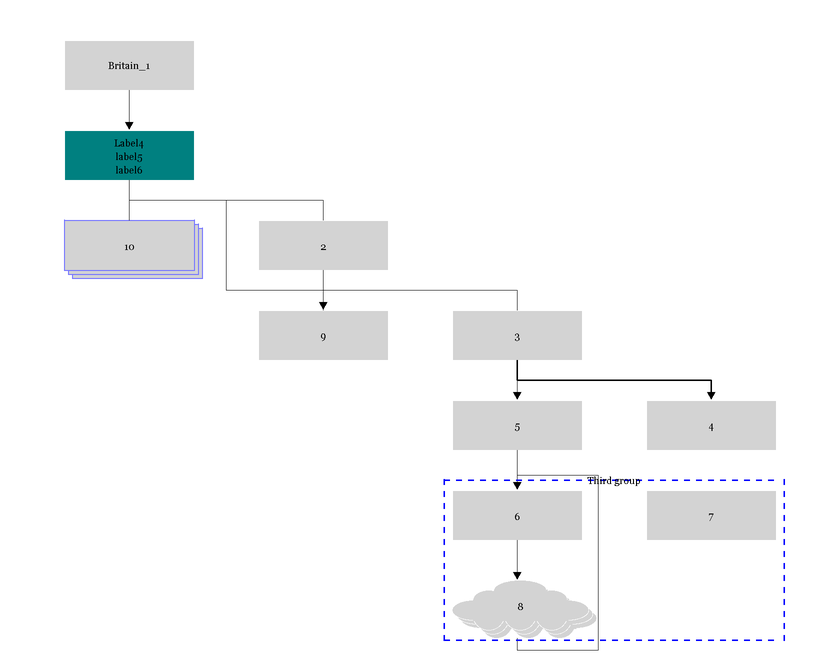

In [180]:
graph_string = """{
//default settings'documentation:
// http://blockdiag.com/en/blockdiag/attributes/diagram.attributes.html?highlight=default#blockdiag_diagram_attr-default_fontsize
// 1 -> 2 makes two nodes with ids of 1 and 2 where 1 has an edge pointing towards 2. Using these ids, a label can
// be written for the nodes as shown. These ids can also be later used for knowing the coordinates of the nodes.
    
    
    // Set span metrix
     //  span_height = 90;
      // span_width = 160;
       
    
    orientation = portrait
        5 -> 6;
        1 -- 10;  
        0 -> 1;   0 [label = "Britain_1"]; //0[fontsize = 25 ]; //0[fontfamily='-sansserif-bold']
        1 -- 2;   1 [label = "Label4  \n label5 \n label6"]
        2 -- 3;   
        3 -> 4[thick];   
        3 -> 5; //5 [shape = "ellipse", stacked] 
        8 -> 6;   8 [shape = "cloud", stacked] 
        1 -- 9;  10 [shape = "box", stacked]; 10 [linecolor =  "#7777FF"];
         
        2 -> 9;   
        
//define default parameters 

   // defaultnode sizes
        node_width =130;
        node_height = 50;
        
    // default colors
        default_node_color = "#d3d3d3";
        
        
        default_group_color = "#7777FF";
        default_linecolor = black;
      
// give a specific color to a node:
      1 [color  = "#008080"];
      
// showing certain nodes in one group:
      group {
              // set the group label text and its color
              label = "Third group";
              color =blue //"#0000FF";

              // Set group shape to 'line group' (default is box)
              shape = line;

              // Set line style (effects to 'line group' only)
              style = dashed;
               6 -> 8 ;7
             }
}"""

output_formatv = "png" #or svg,
default_shadow_color = (255, 255, 255) # RGB white
default_nodeline_color = (255, 255, 255) # RGB white
size=None

tree = parser.parse_string(graph_string)

diagram = blockdiag.builder.ScreenNodeBuilder.build(tree, None)
diagram.separated=True
diagram.set_color('red')
diagram.set_orientation('portrait')


diagram.set_default_linecolor(default_nodeline_color)
metrics = DiagramMetrics(diagram=diagram, drawer=None, fontmap=fontmap)

fontmap = blockdiag.utils.fontmap.FontMap()
fontmap.set_default_font(path = 'c:/windows/fonts\\georgia.ttf')
#fontmap.set_default_fontfamily(fontfamily='serif-bold')
#fontmap.set_default_fontfamily(fontfamily='serif')
fontmap.fontsize =10
#fontmap = _create_fontmap(fontmap=None, font=None)

drawer = blockdiag.drawer.DiagramDraw(_format=output_formatv,
                                      diagram=diagram,
                                      fontmap=fontmap,
                                      code=graph_string,
                                      antialias=True,
                                      nodoctype=False,
                                      transparency=False)

drawer.shadow=default_shadow_color





drawer.draw()
res = drawer.save()
if output_formatv=="png":
    img = Image.open(io.BytesIO(res))
img

In [686]:
parse_df_to_string(input_df)

'{0 -> 1;1 -- 2;2 -- 3;3 -> 4;3 -> 5;5 <-> 6;0 -> 1;0 -> 1;1 -- 2;0 -> 1;1 -- 2;0 -> 1;1 -- 2;0 -> 1;1 -- 2;0 -> 1;1 -- 2;2 -- 3;3 -> 4;3 -> 5;5 <-> 6;0 -> 1;1 -- 2;2 -- 3;3 -> 4;3 -> 5;5 <-> 6;0[node_label="label_0",shape="box",line_color="white",node_color="#d3d3d3",fontsize="10","];1[node_label="label_1",shape="box",line_color="white",node_color="#d3d3d3",fontsize="10","];2[node_label="label_2",shape="box",line_color="white",node_color="#d3d3d3",fontsize="10","];3[node_label="label_3",shape="box",line_color="white",node_color="#d3d3d3",fontsize="10","];4[node_label="label_4",shape="box",line_color="white",node_color="#d3d3d3",fontsize="10","];5[node_label="label_5",shape="box",line_color="white",node_color="#d3d3d3",fontsize="10","];6[node_label="label_6",shape="box",line_color="white",node_color="#d3d3d3",fontsize="10","]orientation = portrait;node_width =130;node_height = 50;default_node_color = "#d3d3d3"; default_group_color = "#7777FF";default_linecolor = black;}'

In [741]:
all_nodes_attributes_string

['0[shape="box",line_color="white",fontsize="10",node_label="label_0",node_color="#d3d3d3"]',
 '1[shape="box",line_color="white",fontsize="10",node_label="label_1",node_color="#d3d3d3"]',
 '2[shape="box",line_color="white",fontsize="10",node_label="label_2",node_color="#d3d3d3"]',
 '3[shape="box",line_color="white",fontsize="10",node_label="label_3",node_color="#d3d3d3"]',
 '4[shape="box",line_color="white",fontsize="10",node_label="label_4",node_color="#d3d3d3"]',
 '5[shape="box",line_color="white",fontsize="10",node_label="label_5",node_color="#d3d3d3"]',
 '6[shape="box",line_color="white",fontsize="10",node_label="label_6",node_color="#d3d3d3"]']

In [149]:
fontpath

'c:/windows/fonts/YuGothR.ttc'

In [23]:
fontmap.fontsize


11

In [10]:
node.fontsize

Getting the coordinates of the boxes which can be used for pasting, for example, flag images on the output pillow image:

In [7]:
nodes_coordinates=[]
nodes_ids=[]
for node in drawer.nodes:
    r = noderenderer.get(node.shape)
    shape = r(node, metrics)
    box = metrics.cell(node).box
    nodes_coordinates.append([box.topleft, box.bottomright, box.width, box.height, box.center])
    nodes_ids.append(int(node.id))
    if int(node.id)==9:
        NODE=node
nodes_info = pd.DataFrame(nodes_coordinates,index=nodes_ids,columns=['top_left', 'bottom_right', 'width', 'height', 'center'])
nodes_info.index.name='node id'
nodes_info

,top_left,bottom_right,width,height,center
node id,,,,,
6,"(258, 490)","(388, 540)",130,50,"(323, 515)"
8,"(258, 580)","(388, 630)",130,50,"(323, 605)"
7,"(452, 580)","(582, 630)",130,50,"(517, 605)"
2,"(64, 130)","(194, 180)",130,50,"(129, 155)"
11,"(64, 220)","(194, 270)",130,50,"(129, 245)"
3,"(258, 220)","(388, 270)",130,50,"(323, 245)"
9,"(646, 220)","(776, 270)",130,50,"(711, 245)"
10,"(840, 220)","(970, 270)",130,50,"(905, 245)"
1,"(64, 40)","(194, 90)",130,50,"(129, 65)"


Getting the coordinates information of the edges:

In [11]:
edges_info=[]
for edge in drawer.edges:
    coordinates = metrics.edge(edge).shaft.xy
    heads = metrics.edge(edge).heads
    if coordinates:
        edges_info.append([edge.node1.id, edge.node2.id, coordinates[0], coordinates[1], heads])        
edges_info = pd.DataFrame(edges_info,columns=['node1 id','node2 id','X','Y','heads'])
edges_info

,node1 id,node2 id,X,Y,heads
0,2,11,129,180,[]
1,2,3,129,180,[]
2,2,10,129,180,[]
3,2,9,129,180,"[[(711, 219), (707, 212), (715, 212), (711, 21..."
4,1,2,129,90,"[[(129, 129), (125, 122), (133, 122), (129, 12..."
5,3,4,323,270,[]
6,4,5,323,360,"[[(323, 399), (319, 392), (327, 392), (323, 39..."
7,5,6,323,450,"[[(323, 489), (319, 482), (327, 482), (323, 48..."
8,9,7,711,278,"[[(517, 579), (513, 572), (521, 572), (517, 57..."
9,6,7,323,540,"[[(517, 579), (513, 572), (521, 572), (517, 57..."


# Pasting flag images

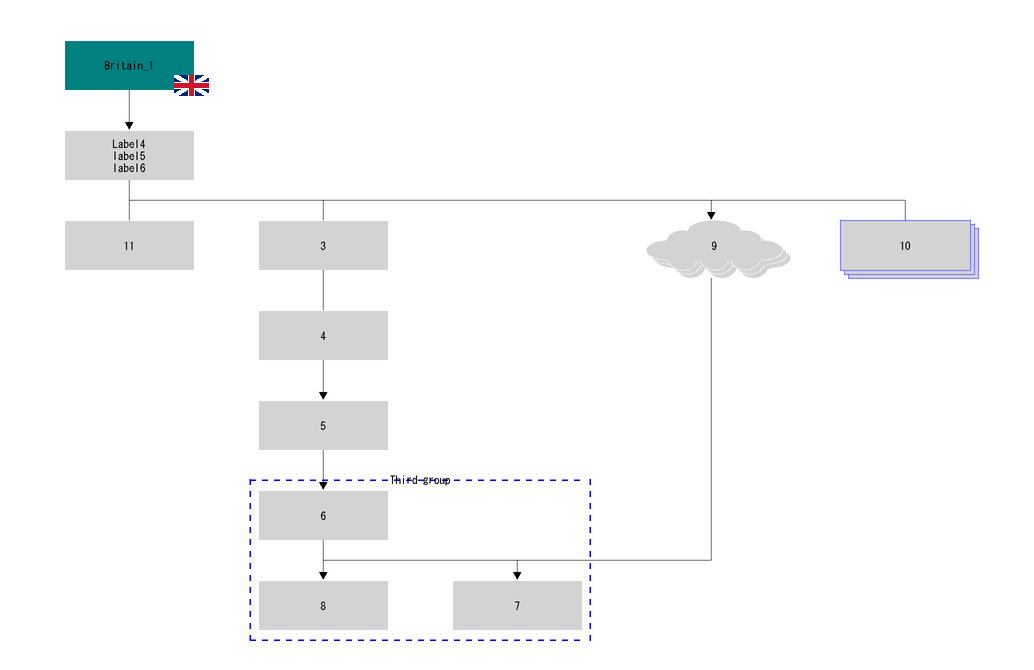

In [12]:
flag_img = Image.open('britain_flag.png', 'r')
flag_img.thumbnail((35,35), Image.ANTIALIAS) # resizing the flag
img.paste(flag_img, (nodes_info.at[1, 'bottom_right'][0]-20,
                     nodes_info.at[1, 'bottom_right'][1]-15))
img

# Writing text on the image

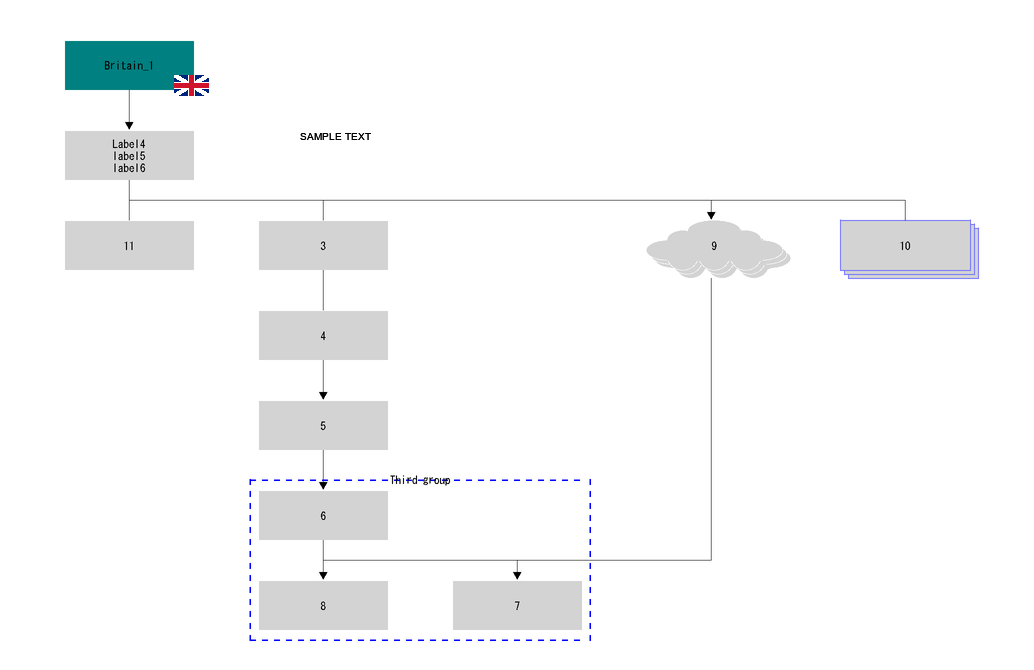

In [14]:
draw = ImageDraw.Draw(img)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((300,130),'SAMPLE TEXT',(0,0,0), font=ImageFont.truetype('arial.ttf', 10))
img